In [2]:
# Imports and Dependencies
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Data Loading
def load_imdb_data():
    from datasets import load_dataset
    dataset = load_dataset("imdb")
    return dataset['train']['text'], dataset['train']['label'], dataset['test']['text'], dataset['test']['label']

In [4]:
# Load the dataset
train_texts, train_labels, test_texts, test_labels = load_imdb_data()

In [5]:
# Dataframe Setup
train_data = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_data = pd.DataFrame({'text': test_texts, 'label': test_labels})

DATA EXPLORATION

Null values:
 text     0
label    0
dtype: int64
Duplicate values: 96


C:\Users\husna ezzah\AppData\Local\Temp\ipykernel_17660\2972752763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='flare')


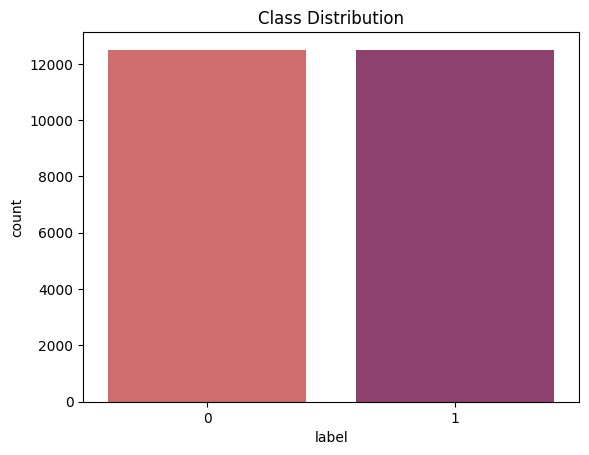

In [6]:
# Data Visualization
def visualize_data(data):
    print("Null values:\n", data.isnull().sum())
    print("Duplicate values:", data.duplicated().sum())
    sns.countplot(x='label', data=data, palette='flare')
    plt.title('Class Distribution')
    plt.show()

visualize_data(train_data)

MODEL EVALUATION

In [7]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=None, max_len=128, is_lstm=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_lstm = is_lstm

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.is_lstm:
            # For LSTM: Convert text to token IDs (simple tokenizer)
            input_ids = [ord(c) % 255 for c in text][:self.max_len]  # Simple char-based tokenizer
            padding = [0] * (self.max_len - len(input_ids))
            input_ids += padding
            return {
                'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            # For BERT-based models: Use Hugging Face tokenizer
            encoding = self.tokenizer.encode_plus(
                text,
                max_length=self.max_len,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }


In [8]:
# Model Definitions
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(256, 128)  # Embedding for ASCII range
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes):
        super().__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(768, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        _, (hidden, _) = self.lstm(bert_output)
        return self.fc(hidden[-1])

In [9]:
# Training and Evaluation
def train_and_evaluate(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=2):
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch.get('attention_mask', None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask) if attention_mask is not None else model(input_ids)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch.get('attention_mask', None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask) if attention_mask is not None else model(input_ids)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cls_report = classification_report(true_labels, predictions, target_names=['Negative', 'Positive'], output_dict=True)
    return accuracy, f1, cls_report

In [10]:
# Data Preparation
max_len = 128
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Tokenizer for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
# Create Datasets and DataLoaders
train_dataset_lstm = CustomDataset(train_data['text'], train_data['label'], is_lstm=True, max_len=max_len)
test_dataset_lstm = CustomDataset(test_data['text'], test_data['label'], is_lstm=True, max_len=max_len)
train_dataset_bert = CustomDataset(train_data['text'], train_data['label'], tokenizer=bert_tokenizer, max_len=max_len)
test_dataset_bert = CustomDataset(test_data['text'], test_data['label'], tokenizer=bert_tokenizer, max_len=max_len)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size)

In [13]:
# Initialize Models
hidden_size = 128
num_classes = 2
lstm_model = LSTMClassifier(hidden_size, num_classes).to(device)
bert_model = BERTClassifier(num_classes).to(device)
bert_lstm_model = BERTLSTMClassifier(bert_model.bert, hidden_size, num_classes).to(device)

In [14]:
# Optimizers
learning_rate = 2e-5
lstm_optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=learning_rate)
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
bert_lstm_optimizer = torch.optim.AdamW(bert_lstm_model.parameters(), lr=learning_rate)

In [21]:
# Initialize a dictionary to store classification reports for all models
all_classification_reports = {}

# Train and Compare Models
results = {}
for name, model, optimizer, train_loader, test_loader in [
    ('LSTM', lstm_model, lstm_optimizer, train_loader_lstm, test_loader_lstm),
    ('BERT', bert_model, bert_optimizer, train_loader_bert, test_loader_bert),
    ('LSTM-BERT', bert_lstm_model, bert_lstm_optimizer, train_loader_bert, test_loader_bert)
]:
    print(f"Training {name}...")
    acc, f1, cls_report = train_and_evaluate(model, train_loader, test_loader, optimizer, nn.CrossEntropyLoss(), device)
    results[name] = {'Accuracy': acc, 'F1 Score': f1}
    
    # Store the classification report
    all_classification_reports[name] = pd.DataFrame(cls_report).transpose()

# Print all classification reports at the end
for name, cls_report_df in all_classification_reports.items():
    print(f"\nClassification Report for {name}:")
    print(cls_report_df)


Training LSTM...
Training BERT...
Training LSTM-BERT...

Classification Report for LSTM:
              precision   recall  f1-score      support
Negative       0.511433  0.50280  0.507080  12500.00000
Positive       0.511053  0.51968  0.515331  12500.00000
accuracy       0.511240  0.51124  0.511240      0.51124
macro avg      0.511243  0.51124  0.511205  25000.00000
weighted avg   0.511243  0.51124  0.511205  25000.00000

Classification Report for BERT:
              precision   recall  f1-score      support
Negative       0.877048  0.89080  0.883870  12500.00000
Positive       0.889060  0.87512  0.882035  12500.00000
accuracy       0.882960  0.88296  0.882960      0.88296
macro avg      0.883054  0.88296  0.882953  25000.00000
weighted avg   0.883054  0.88296  0.882953  25000.00000

Classification Report for LSTM-BERT:
              precision   recall  f1-score      support
Negative       0.912039  0.83696  0.872888  12500.00000
Positive       0.849361  0.91928  0.882938  12500.00000



Model Comparison Results:
LSTM: Accuracy = 0.5112, F1 Score = 0.5112
BERT: Accuracy = 0.8830, F1 Score = 0.8830
LSTM-BERT: Accuracy = 0.8781, F1 Score = 0.8779


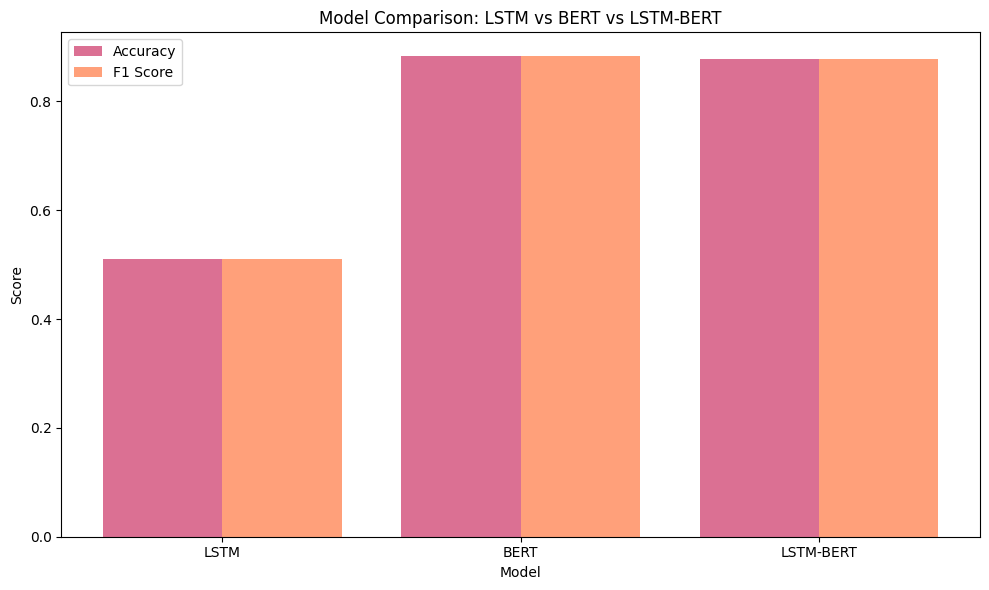

In [24]:
# Print results
print("\nModel Comparison Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['Accuracy']:.4f}, F1 Score = {metrics['F1 Score']:.4f}")

# Plotting Model Comparison
model_names = list(results.keys())
accuracies = [metrics['Accuracy'] for metrics in results.values()]
f1_scores = [metrics['F1 Score'] for metrics in results.values()]

plt.figure(figsize=(10, 6))

# Offsets for side-by-side bars
x = range(len(results))
bar_width = 0.4

plt.bar([i - bar_width / 2 for i in x], accuracies, width=bar_width, color='palevioletred', label='Accuracy')
plt.bar([i + bar_width / 2 for i in x], f1_scores, width=bar_width, color='lightsalmon', label='F1 Score')

# Add labels and title
plt.xticks(x, model_names)
plt.title('Model Comparison: LSTM vs BERT vs LSTM-BERT')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()